# Coupling Coefficient Analysis

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns

sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import handy_roms_spec

import matplotlib as mpl
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore")

In [156]:
gc.collect()

27719

In [2]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder

In [52]:
import seawater as sw
def grid_dist_same(lon,lat):
    import seawater as sw
    if len(lon.shape)==2:
        grid_x=np.zeros(lon.shape)+np.nan
    else:
        grid_x=np.zeros([lat.shape[0],lon.shape[0]])
    
    grid_d=sw.dist(lon=lon,lat=lat)[0]
    grid_x[0:-1,:]=grid_d
    grid_x[-1,:]=grid_d[-1,:]
    
    return grid_x

def area_filter(lon,lat,filter_scale,dim_x,dim_y):
    #paramerers for convolution
    if dim_x=='x_rho' and dim_y=='y_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])
    return gs,radius,circ,Asum

    
def apply_area_filter(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm


def apply_area_filter_t(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[:,radius:-radius,radius:-radius] = var_sm_tmp[:,radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm
    



In [30]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [5]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [7]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'*DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'*DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

In [8]:

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listf_out=glob(path+'*out*');listf_out.sort()
varfout=xr.open_mfdataset(listf_out[-7:])

# path='/data/pacific/lrenault/SASI/SMTH/WRF/'
# listtw=glob(path+'*out*');listtw.sort()
# #vart=xr.open_dataset(listt[xmon])
# vartw=xr.open_mfdataset(listtw[-7:])

In [9]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [10]:
dxx=0.5

### Interpolating WRF variables

In [11]:
tsk_f=regrid(varfout.TSK,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

# tsk_t=regrid(vartout.TSK,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

Create weight file: bilinear_390x300_1520x1000.nc


In [12]:
%%time
# chunks_new={'time_counter':40}
lh_f=regrid(varfw.LH,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# lh_t=regrid(vartw.LH,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

sh_f=regrid(varfw.HFX,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# sh_t=regrid(vartw.HFX,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

swh_f=regrid(varfw.GSW,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #net shortwave
# swh_t=regrid(vartw.GSW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] 


glw_f=regrid(varfw.GLW,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #downwelling long wave (needs to be subtract by S.Boltzman Law
# glw_t=regrid(vartw.GLW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 36s, sys: 3.59 s, total: 1min 40s
Wall time: 1min 49s


#### Long wave heat flux component Calculation

In [13]:
emss=1

# lwh_f=(5.67e-8*(tw_f)**4 - glw_f)
# lwh_t=(5.67e-8*(tw_t)**4 - glw_t)

# lwh_f=(5.67e-8*(tf.data+273.15)**4 - glw_f)
# lwh_t=(5.67e-8*(tt.data+273.15)**4 - glw_t)

lwh_f=(5.67e-8*(tsk_f.data)**4 - glw_f)*emss
# lwh_t=(5.67e-8*(tsk_t.data)**4 - glw_t)*emss

## Reading CROCO variables

In [14]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean('time_counter')
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]


# tt=vart.temp.groupby("time_counter.dayofyear").mean()
# tt=tt.chunk(chunks=chunks_new);
# tt=tt[:,100:-100,100:-200].compute()
# tt=tt[:-1,1:-1,1:-1]


hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,100:-100,100:-200].compute();
hf=hf[:-1,1:-1,1:-1]


# ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
# ht=ht.chunk(chunks=chunks_new);
# ht=ht[:,100:-100,100:-200].compute();
# ht=ht[:-1,1:-1,1:-1]

CPU times: user 23.8 s, sys: 44.1 s, total: 1min 7s
Wall time: 12.2 s


### Net heatflux from WRF

In [15]:
# hwf= swh_f - sh_f - lh_f - lwh_f #this should be the same as CROCO version
# hwt= swh_t - sh_t - lh_t - lwh_t

# Filtering at 50km range

In [16]:
%%time
grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=tf.nav_lon_rho,
                              lat=tf.nav_lat_rho,
                              filter_scale=50,dim_x='x_rho',dim_y='y_rho')

CPU times: user 3min 22s, sys: 4min 46s, total: 8min 9s
Wall time: 8min 9s


In [267]:
%%time
day_i=0


tf_sm=apply_area_filter(tf[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)


hf_sm=apply_area_filter(hf[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)



CPU times: user 51.9 s, sys: 1min 17s, total: 2min 9s
Wall time: 2min 9s


In [273]:
# r_tf_sm=tf_sm.data.ravel()[~np.isnan(tf_sm.data.ravel())]
# r_hf_sm=hf_sm.data.ravel()[~np.isnan(hf_sm.data.ravel())]
r_tf_sm=tf_sm.data[~np.isnan(tf_sm.data)]
r_hf_sm=hf_sm.data[~np.isnan(hf_sm.data)]

# r_tf_f=(tf[day_i]-tf_sm).data.ravel()[~np.isnan(tf_sm.data.ravel())]
# r_hf_f=(hf[day_i]-hf_sm).data.ravel()[~np.isnan(tf_sm.data.ravel())]
r_tf_f=(tf[day_i]-tf_sm).data[~np.isnan(tf_sm.data)]
r_hf_f=(hf[day_i]-hf_sm).data[~np.isnan(tf_sm.data)]

In [275]:
af_sm,bf_sm=np.polyfit(r_tf_sm,r_hf_sm,deg=1)
af_f,bf_f=np.polyfit(r_tf_f,r_hf_f,deg=1)

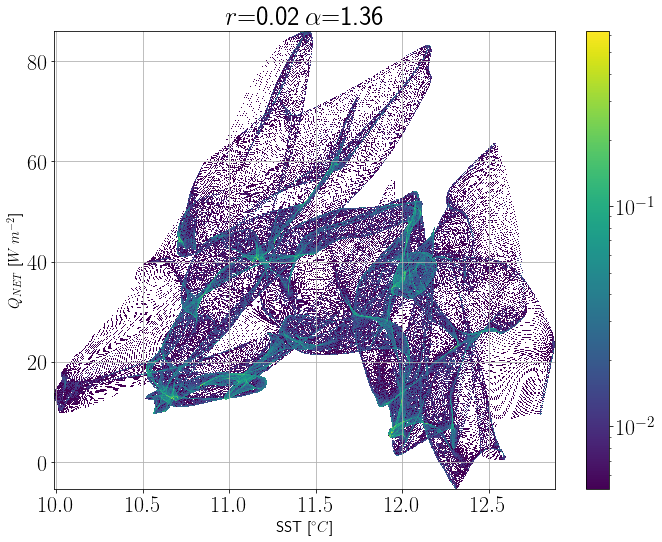

In [276]:


plt.figure(figsize=(10,8))
plt.hist2d(r_tf_sm,r_hf_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_sm,r_hf_sm)[0][1])+ r'$\,\alpha$={0:.2f}'.format(af_sm))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_scatter_t_bar_hfx_bar.png'.format(day_i))

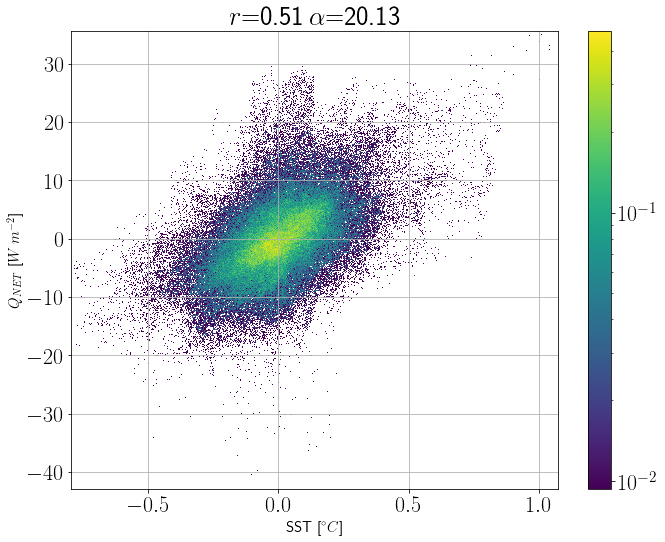

In [277]:
plt.figure(figsize=(10,8))
plt.hist2d(r_tf_f,r_hf_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_hf_f)[0][1])+ r'$\,\alpha$={0:.2f}'.format(af_f))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_scatter_t_prime_hfx_prime.png'.format(day_i))

In [272]:
sh_f=sh_f.rename({'x': 'x_rho','y': 'y_rho'})

lh_f=lh_f.rename({'x': 'x_rho','y': 'y_rho'})

lwh_f=lwh_f.rename({'x': 'x_rho','y': 'y_rho'})

swh_f=swh_f.rename({'x': 'x_rho','y': 'y_rho'})

In [278]:
%%time


sh_f_sm=apply_area_filter(sh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

lh_f_sm=apply_area_filter(lh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

sw_f_sm=apply_area_filter(swh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

lw_f_sm=apply_area_filter(lwh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

CPU times: user 2min 29s, sys: 2min 38s, total: 5min 8s
Wall time: 5min 7s


In [279]:
r_sh_f_sm=sh_f_sm.to_numpy()[~np.isnan(sh_f_sm.to_numpy())]
r_lh_f_sm=lh_f_sm.to_numpy()[~np.isnan(lh_f_sm.to_numpy())]
r_sw_f_sm=sw_f_sm.to_numpy()[~np.isnan(sw_f_sm.to_numpy())]
r_lw_f_sm=lw_f_sm.to_numpy()[~np.isnan(lw_f_sm.to_numpy())]



r_sh_f_f=(sh_f[day_i]-sh_f_sm).to_numpy()[~np.isnan(sh_f_sm.to_numpy())]
r_lh_f_f=(lh_f[day_i]-lh_f_sm).to_numpy()[~np.isnan(lh_f_sm.to_numpy())]
r_sw_f_f=(swh_f[day_i]-sw_f_sm).to_numpy()[~np.isnan(sw_f_sm.to_numpy())]
r_lw_f_f=(lwh_f[day_i]-lw_f_sm).to_numpy()[~np.isnan(lw_f_sm.to_numpy())]




In [280]:
a_r_f,b_r_f=np.polyfit(r_tf_f,(r_sh_f_f+r_lh_f_f),deg=1)
a_r_sm,b_r_sm=np.polyfit(r_tf_sm,(r_sh_f_sm+r_lh_f_sm),deg=1)

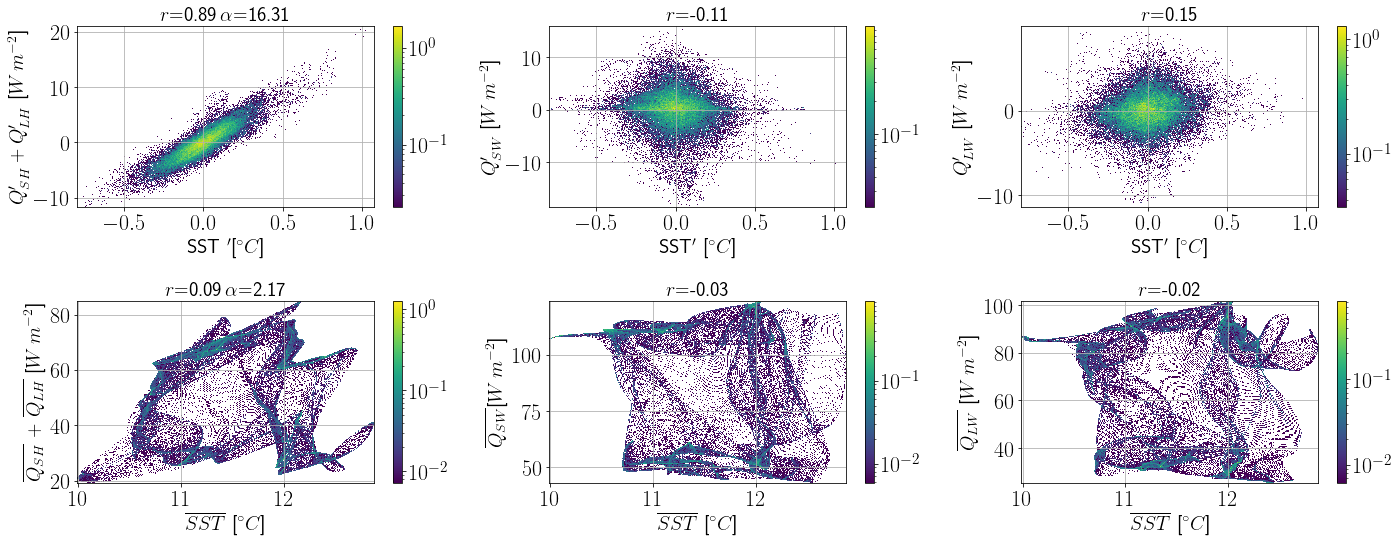

In [281]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.hist2d(r_tf_f,(r_sh_f_f+r_lh_f_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST $^{\prime}$[$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SH}^{\prime} + Q_{LH}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,(r_sh_f_f+r_lh_f_f))[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_r_f),fontsize=20)
plt.colorbar()



plt.subplot(2,3,2)
plt.hist2d(r_tf_f,r_sw_f_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q^{\prime}_{SW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_sw_f_f)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,3)
plt.hist2d(r_tf_f,r_lw_f_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{LW}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_lw_f_f)[0][1]),fontsize=20)
plt.colorbar()




plt.subplot(2,3,4)
plt.hist2d(r_tf_sm,(r_sh_f_sm+r_lh_f_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SH}}$ + $\overline{Q_{LH}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,(r_sh_f_sm+r_lh_f_sm))[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_r_sm),fontsize=20)
plt.colorbar()



plt.subplot(2,3,5)
plt.hist2d(r_tf_sm,r_sw_f_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SW}}$[$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_sw_f_sm)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,6)
plt.hist2d(r_tf_sm,r_lw_f_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{LW}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_lw_f_sm)[0][1]),fontsize=20)
plt.colorbar()


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_scatter_all_TxQ.png'.format(day_i))

In [282]:
a_r_tot,b_r_tot=np.polyfit((r_tf_f+r_tf_sm),(r_sh_f_sm+r_lh_f_sm+r_sh_f_f+r_lh_f_f),deg=1)

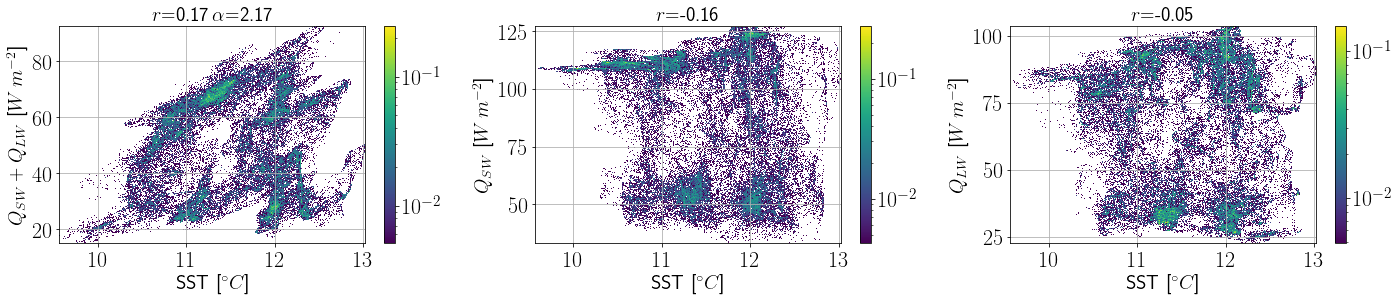

In [283]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.hist2d((r_tf_f+r_tf_sm),(r_sh_f_sm+r_lh_f_sm+r_sh_f_f+r_lh_f_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SW}+ Q_{LW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((r_tf_f+r_tf_sm),
                                               (r_sh_f_sm+r_lh_f_sm+r_sh_f_f+r_lh_f_f))[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_r_tot),fontsize=20)
plt.colorbar()


plt.subplot(2,3,2)
plt.hist2d((r_tf_f+r_tf_sm),(r_sw_f_f+r_sw_f_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((r_tf_f+r_tf_sm),(r_sw_f_f+r_sw_f_sm))[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,3)
plt.hist2d((r_tf_f+r_tf_sm),(r_lw_f_f+r_lw_f_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{LW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((r_tf_f+r_tf_sm),(r_lw_f_f+r_lw_f_sm))[0][1]),fontsize=20)
plt.colorbar()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_original_scatter_all_TxQ.png'.format(day_i))

## Same Analysis, more days for sample

In [77]:
%%time
Tf_sm=np.zeros(tf[::20,:,:].shape)+np.nan;
Hf_sm=np.zeros(hf[::20,:,:].shape)+np.nan;


for ix in range(Tf_sm.shape[0]):
    Tf_sm[ix,:,:]=apply_area_filter(tf[ix],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)


    Hf_sm[ix,:,:]=apply_area_filter(hf[ix],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

CPU times: user 9min 28s, sys: 14min 12s, total: 23min 40s
Wall time: 23min 40s


In [80]:
Tf_sm.shape

(11, 1318, 698)

In [81]:
r_Tf_sm=Tf_sm[~np.isnan(Tf_sm.data)]
r_Hf_sm=Hf_sm[~np.isnan(Hf_sm.data)]

In [82]:
r_Tf_f=(tf[::20].data-Tf_sm)[~np.isnan(Tf_sm)]
r_Hf_f=(hf[::20].data-Hf_sm)[~np.isnan(Tf_sm)]

In [235]:
a_T_f,b_T_f=np.polyfit(r_Tf_f,r_Hf_f,deg=1)
a_T_sm,b_T_sm=np.polyfit(r_Tf_sm,r_Hf_sm,deg=1)

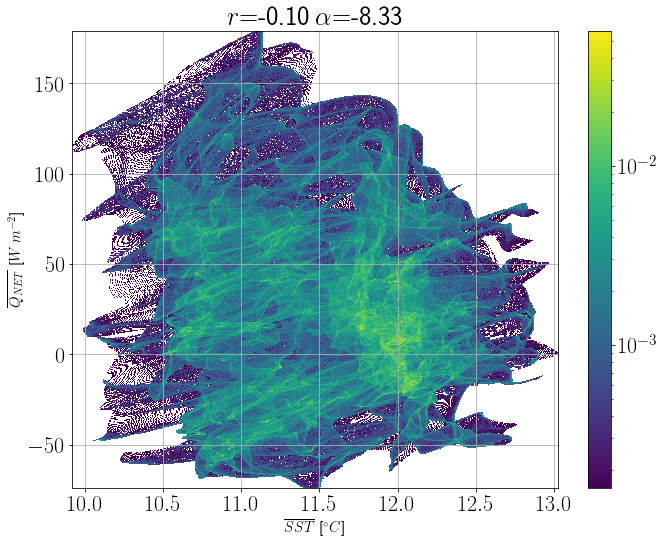

In [265]:


plt.figure(figsize=(10,8))
plt.hist2d(r_Tf_sm,r_Hf_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\overline{Q_{NET}}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_Hf_sm)[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_T_sm))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/TIME_scatter_t_bar_hfx_bar.png')

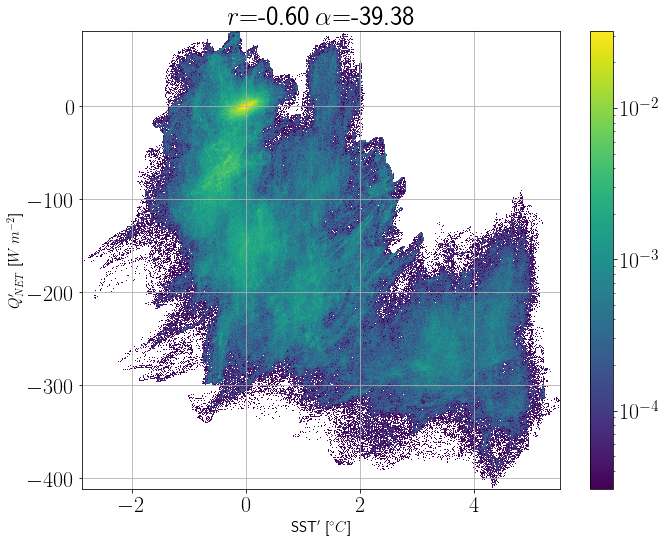

In [266]:
plt.figure(figsize=(10,8))
plt.hist2d(r_Tf_f,r_Hf_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}^{\prime}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_Hf_f)[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_T_f))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/TIME_scatter_t_prime_hfx_prime.png')

In [101]:
# for izz in range(Tf_sm.shape[0]):
#     plt.figure()
#     plt.hist2d((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
#                (hf[::20][izz].data-Hf_sm[izz])[~np.isnan(Hf_sm[izz].data)],bins=1000,density=True,norm=mpl.colors.LogNorm())
#     plt.grid()
#     plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
#     plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
#     plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
#                (hf[::20][izz].data-Hf_sm[izz])[~np.isnan(Hf_sm[izz].data)])[0][1]))




In [103]:
%%time
QH_sm=np.zeros(lh_f[::20,:,:].shape)+np.nan;
SW_sm=np.zeros(swh_f[::20,:,:].shape)+np.nan;
LW_sm=np.zeros(lwh_f[::20,:,:].shape)+np.nan;



for iw in range(QH_sm.shape[0]):
    QH_sm[iw,:,:]=apply_area_filter((sh_f+lh_f)[iw],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    SW_sm[iw,:,:]=apply_area_filter(swh_f[iw],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    LW_sm[iw,:,:]=apply_area_filter(lwh_f[iw],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

CPU times: user 21min 15s, sys: 22min 14s, total: 43min 29s
Wall time: 43min 3s


In [125]:
r_QH_sm=QH_sm[~np.isnan(QH_sm)]
r_SW_sm=SW_sm[~np.isnan(SW_sm)]
r_LW_sm=LW_sm[~np.isnan(LW_sm)]





r_QH_f=(sh_f[::20]+ lh_f[::20] - QH_sm).to_numpy()[~np.isnan(QH_sm)]
r_SW_f=(swh_f[::20] - SW_sm).to_numpy()[~np.isnan(SW_sm)]
r_LW_f=(lwh_f[::20] - LW_sm).to_numpy()[~np.isnan(LW_sm)]


# r_SW_f=(swh_f[day_i]-sw_f_sm).to_numpy()[~np.isnan(sw_f_sm.to_numpy())]
# r_LW_f=(lwh_f[day_i]-lw_f_sm).to_numpy()[~np.isnan(lw_f_sm.to_numpy())]





In [240]:
a_Q_f,b_Q_f=np.polyfit(r_Tf_f,r_QH_f,deg=1)
a_Q_sm,b_Q_sm=np.polyfit(r_Tf_sm,r_QH_sm,deg=1)

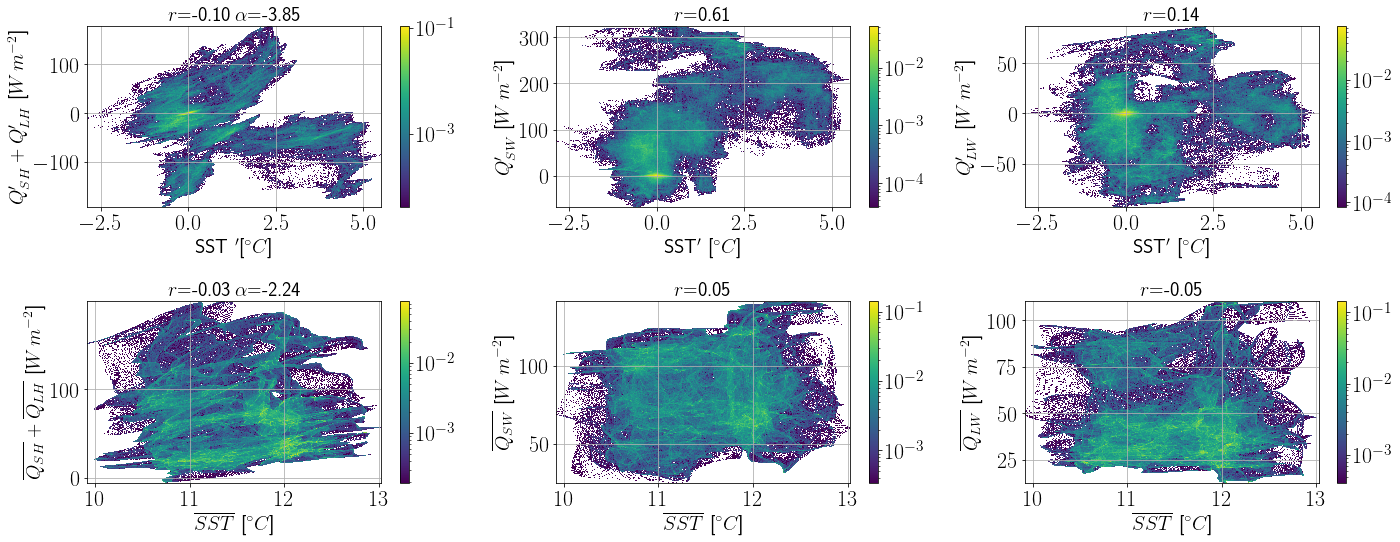

In [284]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.hist2d(r_Tf_f,(r_QH_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST $^{\prime}$[$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SH}^{\prime} + Q_{LH}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_QH_f)[0][1]) + r'$\,\alpha$={0:.2f}'.format(a_Q_f),fontsize=20)
plt.colorbar()



plt.subplot(2,3,2)
plt.hist2d(r_Tf_f,(r_SW_f),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q^{\prime}_{SW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_SW_f)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,3)
plt.hist2d(r_Tf_f,(r_LW_f),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{LW}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_LW_f)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,4)
plt.hist2d(r_Tf_sm,(r_QH_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()

plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SH}} + \overline{Q_{LH}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_QH_sm)[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_Q_sm),fontsize=20)
plt.colorbar()



plt.subplot(2,3,5)
plt.hist2d(r_Tf_sm,(r_SW_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()

plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SW}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_SW_sm)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,6)
plt.hist2d(r_Tf_sm,(r_LW_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{LW}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_LW_sm)[0][1]),fontsize=20)
plt.colorbar()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/TIME_scatter_all_TxQ.png')

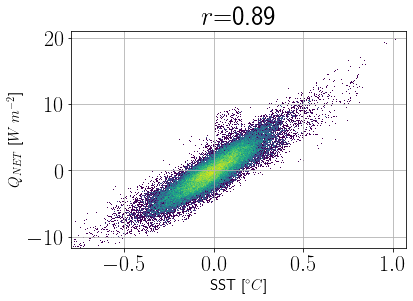

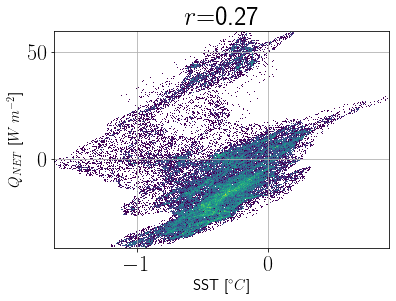

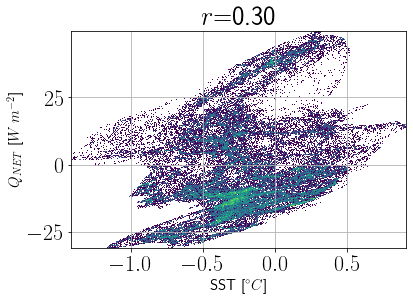

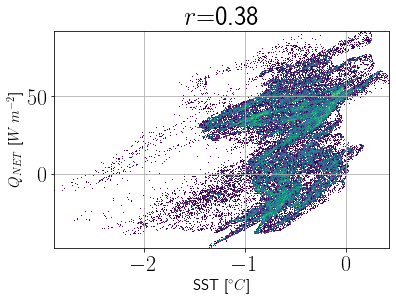

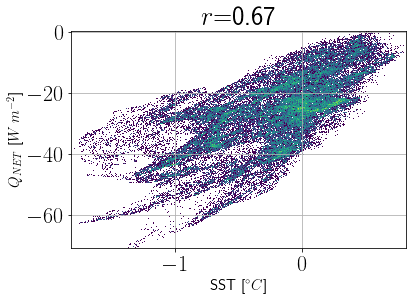

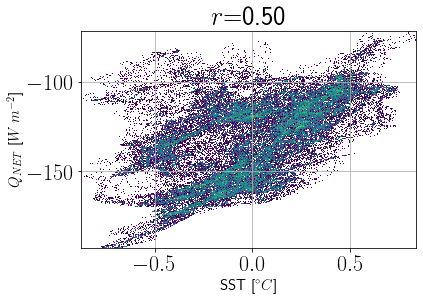

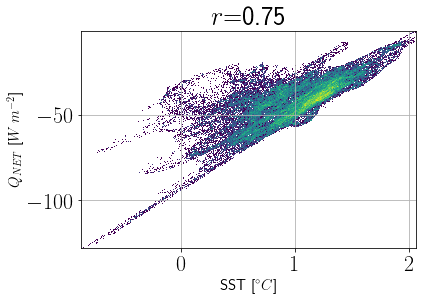

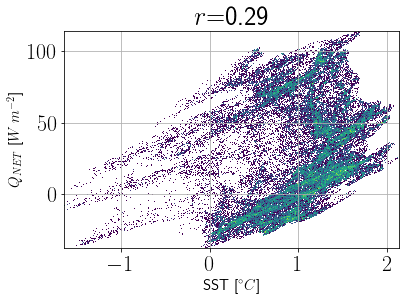

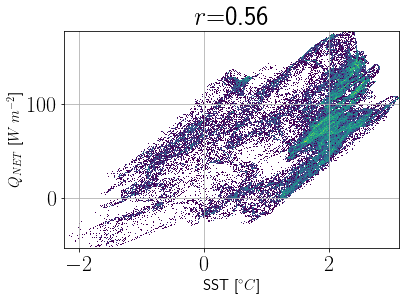

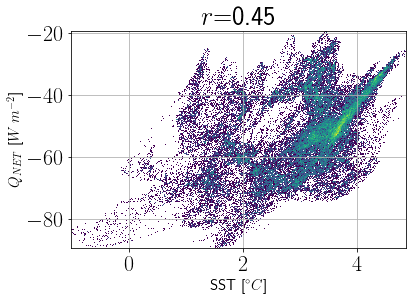

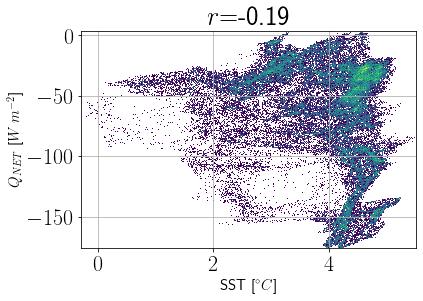

In [139]:
for izz in range(Tf_sm.shape[0]):
    plt.figure()
    plt.hist2d((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
               ((sh_f+lh_f)[::20][izz].data-QH_sm[izz]).compute()[~np.isnan(QH_sm[izz])],
               bins=1000,density=True,norm=mpl.colors.LogNorm())
    plt.grid()
    plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
    plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
    plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
               ((sh_f+lh_f)[::20][izz].data-QH_sm[izz]).compute()[~np.isnan(QH_sm[izz])])[0][1]))


